## Best classifier (Balanced Random forest classifier)

This notebook is used to train and test the best classifier found. It's a random forest classifier. It's trained on all the data of the third day of the experiment except the 42 mice that have been fully annotated. The 42 mice are used as test set.

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import pickle
import os
from sklearn.preprocessing import StandardScaler, Normalizer 
from imblearn.ensemble import BalancedRandomForestClassifier

import sys
sys.path.append('../Library')

import breedManip as breedManip
import dataProcessing as dataProcessing
import breeds as breeds
import splitData as splitData

import importlib
importlib.reload(splitData)

<module 'splitData' from '/mnt/remote/workspaces/magali.egger/TBproject/Travail_Bachelor/ClassificationSimple/../Library/splitData.py'>

#### Preparation of the data

In [73]:
with open('/home/magali.egger/workspace/TBproject/Travail_Bachelor/Data/df_simplify_day3.pkl', 'rb') as f:
    df = pickle.load(f)

In [74]:
len(df['mouse'].unique())

253

They are 252 mice in total in the dataframe. 42 mice were annotated but this include 2 new mice. Which means that in order to create the training set, we need to remove 40 mice from the df, which leaves 212 mice in the training set.

In [75]:
# remove the mice that will be used for testing
mice_test = ['BL601', 'BL602', 'BL606', 'BL609', '1D203', '2D203', '1D204', '1D206', '00505', '04501', '04502', '04504', '04505', '04506', '04508', '04801', '04802', '04803', '04804', '04805', '04806', '05001', '05002', '05003', '05004', '05005', '05006', '07901', '07902', '08405', '08502', '08503', '08901', '08902', '09001', '09003', '09004', '09005', '09006', '09007', '10101', '10102']
df_train = df[~df['mouse'].isin(mice_test)]
len(df_train['mouse'].unique())

213

In [76]:
df_test = df[df['mouse'].isin(mice_test)]
len(df_test['mouse'].unique())

40

#### Training of the classifier

The training of the classifier is made on all the data from the third day except the 40 mice that have been annotated.

In [77]:
# drop the mouse column
df_train = df_train.drop(columns=['mouse'])
df_train = df_train.drop(columns=['breed'])

In [78]:
# separate the data to get the features and the labels
x_train, y_train_raw = splitData.split_labels(df_train)
y_train, le = splitData.encode_labels(y_train_raw, cat_matrix=True)

scaler = StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)

In [79]:
with open('/home/magali.egger/workspace/TBproject/Travail_Bachelor/Data/scaler_best.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [80]:
import warnings
warnings.filterwarnings("ignore")

rfc = BalancedRandomForestClassifier(random_state=23, n_jobs=-1, class_weight='balanced')
rfc.fit(x_train, y_train)

BalancedRandomForestClassifier(class_weight='balanced', n_jobs=-1,
                               random_state=23)

In [81]:
with open('/home/magali.egger/workspace/TBproject/Travail_Bachelor/Data/rfc_best.pkl', 'wb') as f:
    pickle.dump(rfc, f)

#### Computation of the predictions 

The predictions are computed on the 42 mice that have been annotated on all the 4 days of the experiment.

In [82]:
with open('/home/magali.egger/workspace/TBproject/Travail_Bachelor/Data/df_simplify_labels.pkl', 'rb') as f:
    df_simplify_labels = pickle.load(f)

In [83]:
# remove wierd labels
wierd_labels = ['a','8', 's', 'j', '1', '2', '3']
df_simplify_labels = df_simplify_labels[~df_simplify_labels['label'].isin(wierd_labels)]

In [84]:
df_simplify_labels.head()

,Unnamed: 0,rawState,state,EEGv,EMGv,epoch,day,spectral_flatness,spectral_centroid,spectral_entropy,...,EEGv_log,EMGv_log,bias,EEGv^2,EEGv^3,EMGv^2,EMGv^3,mouse,breed,label
0,99,n,n,7.116438e-09,2.315795e-10,99,0,0.054175,9.400168,-5.994889,...,-18.760859,-22.186098,1,5.064369e-17,3.604026e-25,5.362906e-20,1.241939e-29,09003,bxd_090,n
1,100,n,n,6.789003e-09,1.883032e-10,100,0,0.075867,9.576805,-5.910677,...,-18.807962,-22.392967,1,4.609056e-17,3.129089e-25,3.545811e-20,6.676878e-30,09003,bxd_090,n
2,101,n,n,5.345885e-09,1.965400e-10,101,0,0.082830,10.181243,-5.931538,...,-19.046939,-22.350155,1,2.857849e-17,1.527773e-25,3.862797e-20,7.591942e-30,09003,bxd_090,n
3,102,n,n,8.861552e-09,1.982735e-10,102,0,0.052586,7.561301,-5.506340,...,-18.541544,-22.341374,1,7.852710e-17,6.958720e-25,3.931238e-20,7.794603e-30,09003,bxd_090,n
4,103,n,n,6.617297e-09,2.121310e-10,103,0,0.068133,8.691670,-5.728127,...,-18.833579,-22.273817,1,4.378862e-17,2.897624e-25,4.499956e-20,9.545802e-30,09003,bxd_090,n


In [85]:
df_simplify_labels = df_simplify_labels.drop(columns=['mouse'])
df_simplify_labels = df_simplify_labels.drop(columns=['breed'])

In [86]:
x_test, y_test_raw = splitData.split_labels_annotated(df_simplify_labels)
x_test = scaler.transform(x_test)

In [87]:
y_test_raw.unique()

array(['n', 'w', 'r', '9', '5', '6', '4'], dtype=object)

In [88]:
def convert(states):
    res = []
    for state in states:
        if state == 'n' or state == '5' or state=='2':
            res.append(0)
        elif state == 'r' or state=='6' or state=='3':
            res.append(1)
        elif state == 'w' or state=='4' or state=='1' or state=='9':
            res.append(2)
    return res

In [89]:
y_test = convert(y_test_raw)

In [90]:
y_pred = rfc.predict(x_test)

[[1256207   18577   67765]
 [  51948  100988   21211]
 [ 104899   13320 1414304]]
              precision    recall  f1-score   support

           n       0.89      0.94      0.91   1342549
           r       0.76      0.58      0.66    174147
           w       0.94      0.92      0.93   1532523

    accuracy                           0.91   3049219
   macro avg       0.86      0.81      0.83   3049219
weighted avg       0.91      0.91      0.91   3049219



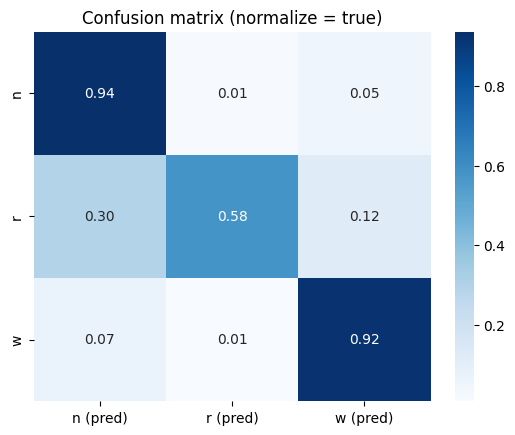

In [92]:
from sklearn.metrics import classification_report, confusion_matrix
pred = np.argmax(y_pred, axis=1)
test = y_test

# plot the confusion matrix between predictions of the model and real values

cm = np.array(confusion_matrix(test, pred))
print(cm)

cm = np.array(confusion_matrix(test, pred, normalize='true')) # normalize = 'true' or 'pred'
confusion = pd.DataFrame(cm, index=le.classes_, columns=le.classes_ + ' (pred)')

print(classification_report(test, pred, target_names=le.classes_, zero_division=0))

sns.heatmap(confusion, annot=True, cmap="Blues", fmt='.2f')
plt.title(f'Confusion matrix (normalize = true)')
plt.show()